In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import urllib, json
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.graphics.gofplots import qqplot
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from scipy import stats

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [69]:
df = pd.read_pickle("econ_sample.pkl") 
df.head()
df.columns

,tweetid,userid,screen_name,date,lang,state,country,tweet_type,friends_count,verified,hashtag,rt_screen,rt_userid,rt_text,sent_vader,qtd_screen,qtd_userid,qtd_text
15204,1456699658852503552,758103579286581248,janvinjoey,2021-11-05 19:07:17+00:00,en,NJ,United States,retweeted_tweet_without_comment,8080,False,[],TomiLahren,4.686470e+08,My dad is now one of those people who is force...,-0.8852,NaN,NaN,NaN
106384,1391133712335753216,48149612,coco_roberts13,2021-05-08 20:51:37+00:00,en,NaN,NaN,retweeted_tweet_without_comment,852,False,[],SenSanders,2.944231e+07,Providing an extra $300 a week in unemployment...,-0.1813,NaN,NaN,NaN
81608,1334342185605615616,381244658,0lufem,2020-12-03 03:42:22+00:00,en,NaN,NaN,retweeted_tweet_without_comment,341,False,[],Ilhan,1.082334e+18,It’s been 200 days since the House passed the ...,0.9251,NaN,NaN,NaN
56475,1282109428645294080,112902058,InvestWatchBlog,2020-07-12 00:28:02+00:00,en,NaN,United States,original,480,False,[],NaN,NaN,NaN,-0.4404,NaN,NaN,NaN
8381,1475859762071982080,361703035,Unbreakable_B,2021-12-28 16:02:42+00:00,en,MA,United States,retweeted_tweet_without_comment,544,False,[],foxstrology,1.014295e+18,no free tests. no free masks. no lockdown. no ...,-0.7650,NaN,NaN,NaN


Index(['tweetid', 'userid', 'screen_name', 'date', 'lang', 'state', 'country',
       'tweet_type', 'friends_count', 'verified', 'hashtag', 'rt_screen',
       'rt_userid', 'rt_text', 'sent_vader', 'qtd_screen', 'qtd_userid',
       'qtd_text'],
      dtype='object')

In [70]:
## Function to help with various significance testing

def compare_sentiment(df, column):
    # Group sentiment scores for each political affiliation
    red_scores = df[df[column] & (df['political_affil'] == 'Red')]['sent_vader']
    blue_scores = df[df[column] & (df['political_affil'] == 'Blue')]['sent_vader']
    flip_scores = df[df[column] & (df['political_affil'] == 'Flip')]['sent_vader']
    
    # Check normality and variance
    # Shapiro-Wilk test for normality
    print("Red normality p-value:", stats.shapiro(red_scores).pvalue)
    print("Blue normality p-value:", stats.shapiro(blue_scores).pvalue)
    print("Flip normality p-value:", stats.shapiro(flip_scores).pvalue)

    # Levene’s test for equal variances
    print("Levene test p-value:", stats.levene(red_scores, blue_scores, flip_scores).pvalue)

    # If normal and equal variances:
    if stats.shapiro(red_scores).pvalue > 0.05 and stats.shapiro(blue_scores).pvalue > 0.05 and stats.shapiro(flip_scores).pvalue > 0.05:
        if stats.levene(red_scores, blue_scores, flip_scores).pvalue > 0.05:
            anova_result = stats.f_oneway(red_scores, blue_scores, flip_scores)
            print("ANOVA p-value:", anova_result.pvalue)
        else:
            # If variances are unequal, use Kruskal-Wallis
            kruskal_result = stats.kruskal(red_scores, blue_scores, flip_scores)
            print("Kruskal-Wallis p-value:", kruskal_result.pvalue)
    else:
        # If not normal, use Kruskal-Wallis
        kruskal_result = stats.kruskal(red_scores, blue_scores, flip_scores)
        print("Kruskal-Wallis p-value:", kruskal_result.pvalue)


In [71]:
# Counting the distribution of tweets per state
df['state'].value_counts()

state
CA    46852
NY    28182
TX    27681
FL    22694
IL    12104
PA    10196
OH     9654
DC     9105
GA     8828
MI     8362
NC     7902
MA     7860
AZ     7558
NJ     6944
WA     6795
VA     6346
CO     6224
OR     5610
MD     5175
TN     5055
MN     4453
IN     4153
WI     3661
NV     3516
SC     3240
MO     3092
KY     2895
AL     2811
CT     2638
OK     2522
IA     1996
KS     1962
AR     1719
UT     1602
NM     1579
LA     1368
HI     1299
ME     1281
NE     1163
MS     1142
WV     1120
NH     1090
ID     1042
RI      936
MT      842
DE      813
AK      707
VT      638
SD      496
ND      329
WY      322
Name: count, dtype: int64

In [72]:
# Adding political affiliations by state
political_affil_state = {
    'MT': 'Red', 'ID': 'Red', 'UT': 'Red', 'WY': 'Red',
    'SD': 'Red', 'ND': 'Red', 'NE': 'Red', 'IA': 'Red',
    'MO': 'Red', 'KS': 'Red', 'OK': 'Red', 'TX': 'Red',
    'AR': 'Red', 'LA': 'Red', 'MS': 'Red', 'AL': 'Red',
    'TN': 'Red', 'KY': 'Red', 'IN': 'Red', 'OH': 'Red',
    'WV': 'Red', 'NC': 'Red', 'SC': 'Red', 'FL': 'Red', 'AK': 'Red', #Red states
    
    'WA': 'Blue', 'OR': 'Blue', 'NV': 'Blue', 'CA': 'Blue',
    'NM': 'Blue', 'CO': 'Blue', 'MN': 'Blue', 'IL': 'Blue',
    'NY': 'Blue', 'VA': 'Blue', 'NJ': 'Blue', 'MD': 'Blue',
    'DE': 'Blue', 'CT': 'Blue', 'MA': 'Blue', 'RI': 'Blue',
    'NH': 'Blue', 'VT': 'Blue', 'ME': 'Blue', 'HI': 'Blue', #Blue states
    
    'AZ': 'Flip', 'WI': 'Flip', 'MI': 'Flip', 'GA': 'Flip', 
    'PA': 'Flip'} #Flip states

def get_political_affil(state):
    #default to 'Unknown' if the state abbreviation is not found in the mapping
    return political_affil_state.get(state, 'Unknown')
df['political_affil'] = df['state'].apply(get_political_affil)
df['political_affil']

15204        Blue
106384    Unknown
81608     Unknown
56475     Unknown
8381         Blue
           ...   
136351    Unknown
17371        Flip
108753        Red
31214     Unknown
58332     Unknown
Name: political_affil, Length: 1000000, dtype: object

In [73]:
#get 5 states from flip, red, and blue with the most tweets

# Grouping by political affiliation and state
state_counts = df.groupby(['political_affil', 'state']).size().reset_index(name='tweet_count')

# Sorting by tweet count and getting the top 5 for each political affiliation
top_states = state_counts.sort_values(by='tweet_count', ascending=False)

# Getting the top 5 states per political affiliation
top_5_red = top_states[top_states['political_affil'] == 'Red'].head(5)
top_5_blue = top_states[top_states['political_affil'] == 'Blue'].head(5)
top_5_flip = top_states[top_states['political_affil'] == 'Flip'].head(5)

# Combining the top 5 states
top_states_combined = pd.concat([top_5_red, top_5_blue, top_5_flip])

print(top_states_combined)

   political_affil state  tweet_count
46             Red    TX        27681
28             Red    FL        22694
41             Red    OH         9654
38             Red    NC         7902
45             Red    TN         5055
0             Blue    CA        46852
14            Blue    NY        28182
5             Blue    IL        12104
6             Blue    MA         7860
11            Blue    NJ         6944
23            Flip    PA        10196
21            Flip    GA         8828
22            Flip    MI         8362
20            Flip    AZ         7558
24            Flip    WI         3661


In [74]:
## Cleaning text and converting to lowercase
df.rt_text = df.rt_text.fillna("")
df.rt_text = df.rt_text.str.lower()

In [75]:
# Value counter for keywords
df.rt_text.str.lower().str.contains("biden").value_counts()


rt_text
False    956963
True      43037
Name: count, dtype: int64

### Keyword: "anti-vax"

#### Not statistically significant

In [76]:
# Testing antivax
df["is_antivax"] = df.rt_text.str.lower().str.contains("anti-vax")
df.rt_text.str.lower().str.contains("anti-vax").value_counts()
df[ df.is_antivax & (df.political_affil == "Red") ].sent_vader.mean()
df[ df.is_antivax & (df.political_affil == "Blue") ].sent_vader.mean()
df[ df.is_antivax & (df.political_affil == "Blue") ].sent_vader.mean()

compare_sentiment(df, 'is_antivax')

rt_text
False    999455
True        545
Name: count, dtype: int64

-0.36262555555555565

-0.32453963963963967

-0.32453963963963967

Red normality p-value: 1.4763671122281019e-10
Blue normality p-value: 1.3327672063172293e-11
Flip normality p-value: 9.38063333031483e-06
Levene test p-value: 0.22414972947442846
Kruskal-Wallis p-value: 0.6236145523963719


### Keyword: "get vaccin"

#### Not statistically significant

In [77]:
# Testing provax sentiment
df["is_provax"] = df.rt_text.str.lower().str.contains("get vaccin")
df.rt_text.str.lower().str.contains("get vaccin").value_counts()
df[ df.is_provax & (df.political_affil == "Red") ].sent_vader.mean()
df[ df.is_provax & (df.political_affil == "Blue") ].sent_vader.mean()
df[ df.is_provax & (df.political_affil == "Flip") ].sent_vader.mean()

compare_sentiment(df, 'is_provax')

rt_text
False    998179
True       1821
Name: count, dtype: int64

0.6435202380952381

0.6911035805626599

0.7032029702970298

Red normality p-value: 6.192110307249192e-27
Blue normality p-value: 2.9109969525155064e-34
Flip normality p-value: 3.98230077423484e-18
Levene test p-value: 0.3893990032525044
Kruskal-Wallis p-value: 0.1364214609336928


### Keyword: "vaccine"

#### Statistically significant at the 5% level

In [78]:
# Testing vaccine
df["vaxx"] = df.rt_text.str.lower().str.contains("vaccine")
df.rt_text.str.lower().str.contains("vaccine").value_counts()
df[ df.vaxx & (df.political_affil == "Red") ].sent_vader.mean()
df[ df.vaxx & (df.political_affil == "Blue") ].sent_vader.mean()
df[ df.vaxx & (df.political_affil == "Flip") ].sent_vader.mean()

compare_sentiment(df, 'vaxx')

rt_text
False    976236
True      23764
Name: count, dtype: int64

-0.1189768672951414

-0.05325394040657198

-0.05915387797311271

Red normality p-value: 8.092646562514334e-45
Blue normality p-value: 3.723569690896591e-49
Flip normality p-value: 2.5469249245867393e-27
Levene test p-value: 0.00011069856172036036
Kruskal-Wallis p-value: 0.00032654895277691657


### Keyword: "anti-mask"

#### Not statistically significant

In [79]:
# Testing anti-mask
df["anti_mask"] = df.rt_text.str.lower().str.contains("anti-mask")
df.rt_text.str.lower().str.contains("anti-mask").value_counts()
df[ df.anti_mask & (df.political_affil == "Red") ].sent_vader.mean()
df[ df.anti_mask & (df.political_affil == "Blue") ].sent_vader.mean()
df[ df.anti_mask & (df.political_affil == "Flip") ].sent_vader.mean()

compare_sentiment(df, 'anti_mask')

rt_text
False    999814
True        186
Name: count, dtype: int64

-0.7626473684210527

-0.7893526315789474

-0.7167499999999999

Red normality p-value: 2.263829720087517e-08
Blue normality p-value: 9.999415607817105e-12
Flip normality p-value: 1.207284557509645e-06
Levene test p-value: 0.7484884666663512
Kruskal-Wallis p-value: 0.7048055459677519


### Keyword: "wear a mask"

#### Not statistically significant

In [80]:
# Testing wear a mask
df["wear_mask"] = (df.rt_text.str.lower().str.contains("wear a mask") & ~df.rt_text.str.lower().str.contains("don't wear a mask"))
df.rt_text.str.lower().str.contains("wear a mask").value_counts()

df[ df.wear_mask & (df.political_affil == "Red") ].sent_vader.mean()
df[ df.wear_mask & (df.political_affil == "Blue") ].sent_vader.mean()
df[ df.wear_mask & (df.political_affil == "Flip") ].sent_vader.mean()

compare_sentiment(df, 'wear_mask')

rt_text
False    999286
True        714
Name: count, dtype: int64

-0.48951578947368424

-0.5450642335766424

-0.5292821428571428

Red normality p-value: 6.8026923746363145e-12
Blue normality p-value: 5.08069194911235e-14
Flip normality p-value: 6.45892679138154e-05
Levene test p-value: 0.7367427372445934
Kruskal-Wallis p-value: 0.2790416704676289


### Keyword: "vaccination"

#### Not statistically significant

Red normality p-value: 1.1476102853052504e-18
Blue normality p-value: 1.4879772200096226e-21
Flip normality p-value: 1.634195048280193e-09
Levene test p-value: 0.38753277736363434
Kruskal-Wallis p-value: 0.006430161829368729


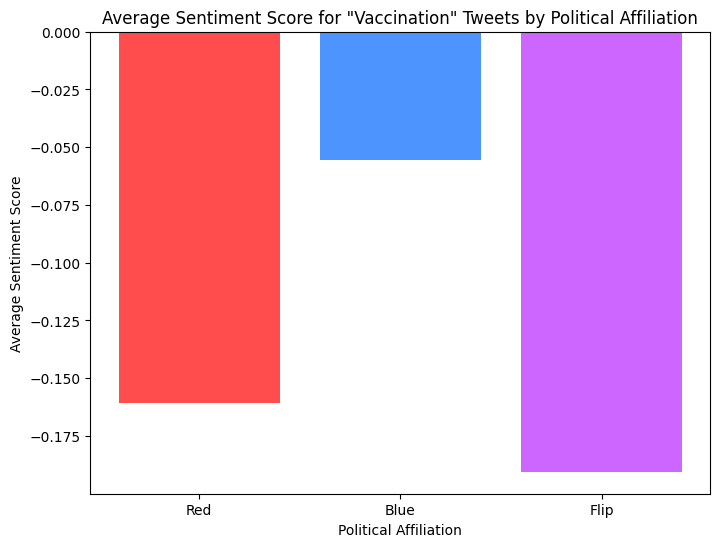

In [81]:
# Testing vaccination
df["vaccination"] = df.rt_text.str.lower().str.contains("vaccination")
df.rt_text.str.lower().str.contains("vaccination").value_counts()
df[ df.vaccination & (df.political_affil == "Red") ].sent_vader.mean()
df[ df.vaccination & (df.political_affil == "Blue") ].sent_vader.mean()
df[ df.vaccination & (df.political_affil == "Flip") ].sent_vader.mean()

compare_sentiment(df, 'vaccination')

# Calculate the average sentiment score for each political affiliation
red_sentiment = df[df['vaccination'] & (df['political_affil'] == 'Red')]['sent_vader'].mean()
blue_sentiment = df[df['vaccination'] & (df['political_affil'] == 'Blue')]['sent_vader'].mean()
flip_sentiment = df[df['vaccination'] & (df['political_affil'] == 'Flip')]['sent_vader'].mean()

affiliations = ['Red', 'Blue', 'Flip']
sentiment_scores = [red_sentiment, blue_sentiment, flip_sentiment]

# Bar plot
plt.figure(figsize=(8, 6))
plt.bar(affiliations, sentiment_scores, color=['#ff4d4d', '#4d94ff', '#cc66ff'])
plt.xlabel('Political Affiliation')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Score for "Vaccination" Tweets by Political Affiliation')
plt.savefig('00_vaccination_avg.png')
plt.show();


/var/folders/q4/7sz5khj51k3c5cv3fz08lsb40000gn/T/ipykernel_30623/2541371904.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_vaccination, x='political_affil', y='sent_vader', palette=color_palette)


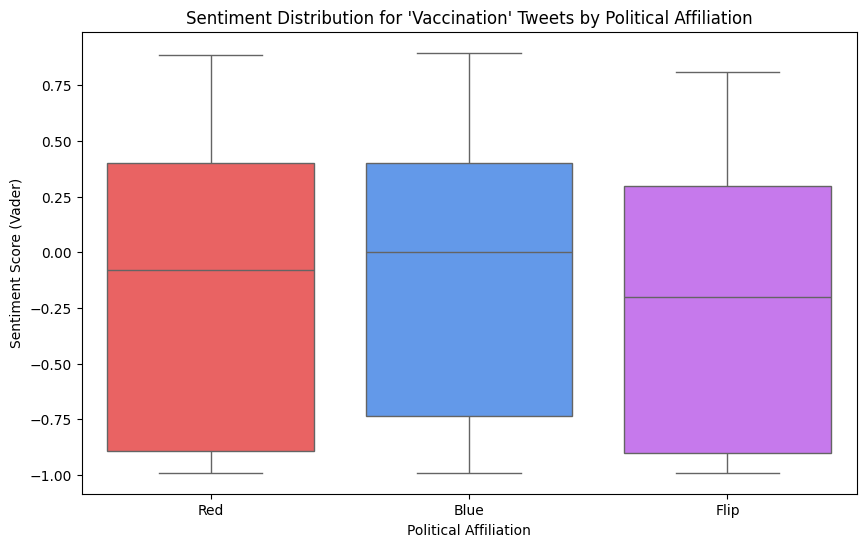

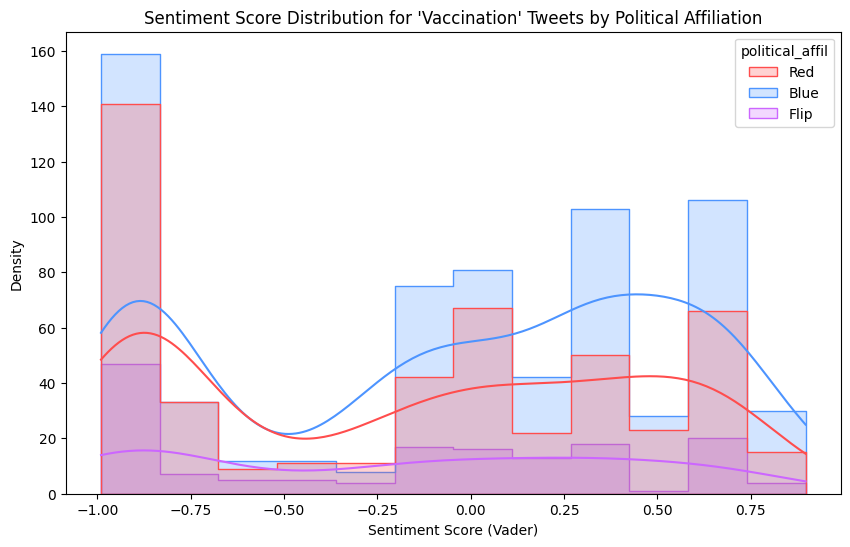

In [82]:
# filtering dataframe
df_vaccination = df[df['vaccination']]
df_vaccination = df_vaccination[df_vaccination['political_affil'] != 'Unknown']

color_palette = {"Red": "#ff4d4d", "Blue": "#4d94ff", "Flip": "#cc66ff"}

# box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_vaccination, x='political_affil', y='sent_vader', palette=color_palette)
plt.title("Sentiment Distribution for 'Vaccination' Tweets by Political Affiliation")
plt.xlabel("Political Affiliation")
plt.ylabel("Sentiment Score (Vader)")
plt.savefig('01_vaccination_distrib.png')
plt.show();

# KDE plot to check sentiment distribution 
plt.figure(figsize=(10, 6))
sns.histplot(data=df_vaccination, x='sent_vader', hue='political_affil', kde=True, element="step", palette=color_palette)
plt.title("Sentiment Score Distribution for 'Vaccination' Tweets by Political Affiliation")
plt.xlabel("Sentiment Score (Vader)")
plt.ylabel("Density")
plt.savefig('02_vaccination_kde.png')
plt.show();


In [83]:
# Extract individual sentiment values for each group
red_sentiment_vacc = df[df['vaccination'] & (df['political_affil'] == 'Red')]['sent_vader']
blue_sentiment_vacc = df[df['vaccination'] & (df['political_affil'] == 'Blue')]['sent_vader']
flip_sentiment_vacc = df[df['vaccination'] & (df['political_affil'] == 'Flip')]['sent_vader']

# Combine data into a single DataFrame for Tukey's test
data = pd.concat([
    pd.DataFrame({'sentiment': red_sentiment_vacc, 'group': 'Red'}),
    pd.DataFrame({'sentiment': blue_sentiment_vacc, 'group': 'Blue'}),
    pd.DataFrame({'sentiment': flip_sentiment_vacc, 'group': 'Flip'})
])

# Perform Tukey's HSD test
tukey_result_vacc = pairwise_tukeyhsd(endog=data['sentiment'], groups=data['group'], alpha=0.05)
print(tukey_result_vacc)

# Converting to image
#result_str = tukey_result_vacc.summary().as_text()
#fig, ax = plt.subplots(figsize=(10, 5))
#ax.axis('off')
#ax.text(0.01, 0.99, result_str, transform=ax.transAxes, fontsize=10,
#        verticalalignment='top', family='monospace')
# plt.savefig('03_vaccination_tukey.png')


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  Blue   Flip  -0.1351 0.0302 -0.2599 -0.0102   True
  Blue    Red  -0.1052 0.0088 -0.1886 -0.0218   True
  Flip    Red   0.0299 0.8506 -0.0995  0.1593  False
----------------------------------------------------


### Keyword: "covid lockdown"

#### Statistically significant at the 10% level

In [84]:
# Testing lockdown
df["covid_lockdown"] = df.rt_text.str.lower().str.contains("covid lockdown")
df.rt_text.str.lower().str.contains("covid lockdown").value_counts()
df[ df.covid_lockdown & (df.political_affil == "Red") ].sent_vader.mean()
df[ df.covid_lockdown & (df.political_affil == "Blue") ].sent_vader.mean()

compare_sentiment(df, 'covid_lockdown')

rt_text
False    999353
True        647
Name: count, dtype: int64

-0.5627958904109588

-0.410363076923077

Red normality p-value: 2.0333723651093845e-11
Blue normality p-value: 1.9552515416256397e-06
Flip normality p-value: 0.00021912777396843253
Levene test p-value: 0.23240041552227822
Kruskal-Wallis p-value: 0.08007013640688909


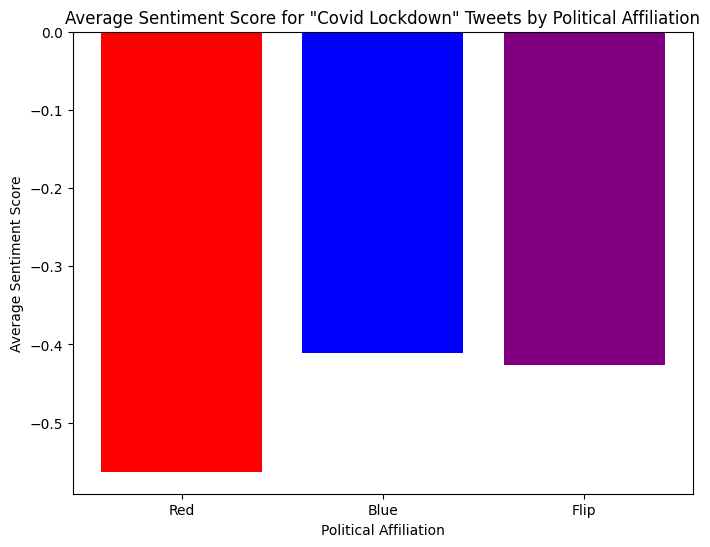

/var/folders/q4/7sz5khj51k3c5cv3fz08lsb40000gn/T/ipykernel_30623/3541071045.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_cov, x='political_affil', y='sent_vader', palette=color_palette)


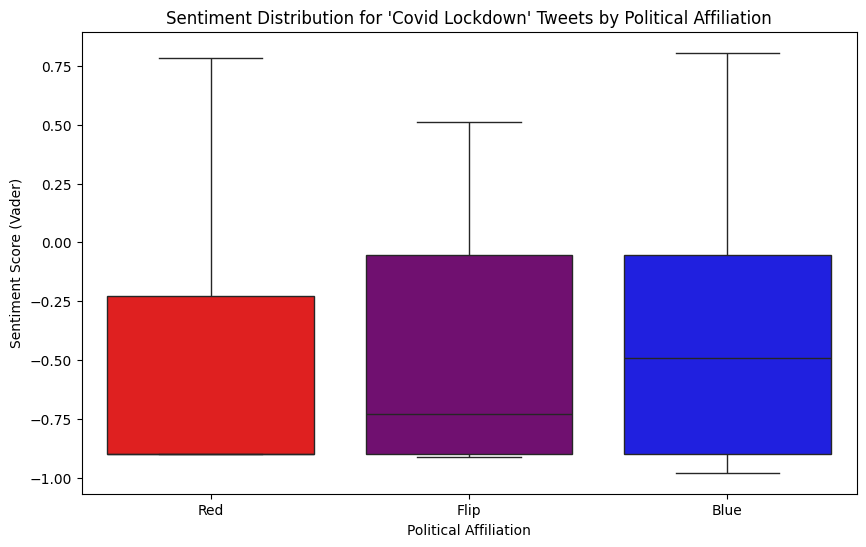

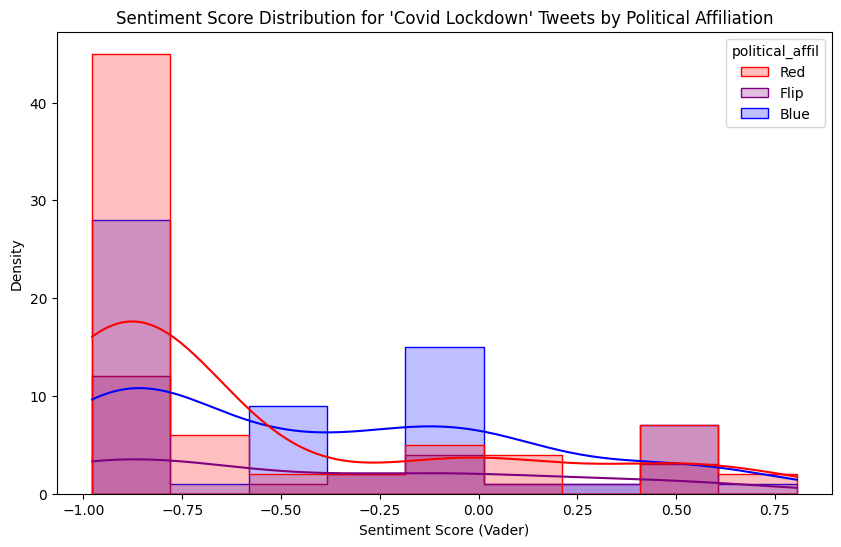

In [85]:
# Calculate the average sentiment score for each political affiliation
red_sentiment_cov = df[df['covid_lockdown'] & (df['political_affil'] == 'Red')]['sent_vader'].mean()
blue_sentiment_cov = df[df['covid_lockdown'] & (df['political_affil'] == 'Blue')]['sent_vader'].mean()
flip_sentiment_cov = df[df['covid_lockdown'] & (df['political_affil'] == 'Flip')]['sent_vader'].mean()

# Prepare data for plotting
affiliations = ['Red', 'Blue', 'Flip']
sentiment_scores_cov = [red_sentiment_cov, blue_sentiment_cov, flip_sentiment_cov]

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(affiliations, sentiment_scores_cov, color=['red', 'blue', 'purple'])
plt.xlabel('Political Affiliation')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Score for "Covid Lockdown" Tweets by Political Affiliation')
plt.savefig('04_lockdown_avg.png')
plt.show();


# Filter the DataFrame to include only rows where the tweet mentions "vaccination"
df_cov = df[df['covid_lockdown']]
df_cov = df_cov[df_cov['political_affil'] != 'Unknown']

color_palette = {"Red": "red", "Blue": "blue", "Flip": "purple"}


# Box plot to show the distribution of sentiment scores by political affiliation for "vaccination" tweets
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_cov, x='political_affil', y='sent_vader', palette=color_palette)
plt.title("Sentiment Distribution for 'Covid Lockdown' Tweets by Political Affiliation")
plt.xlabel("Political Affiliation")
plt.ylabel("Sentiment Score (Vader)")
plt.savefig('05_lockdown_distrib.png')
plt.show();

# KDE plot to check sentiment distribution for each political affiliation for "vaccination" tweets
plt.figure(figsize=(10, 6))
sns.histplot(data=df_cov, x='sent_vader', hue='political_affil', kde=True, element="step", palette=color_palette)
plt.title("Sentiment Score Distribution for 'Covid Lockdown' Tweets by Political Affiliation")
plt.xlabel("Sentiment Score (Vader)")
plt.ylabel("Density")
plt.savefig('06_lockdown_kde.png')
plt.show();


In [86]:
# extract values
red_sentiment_cov = df[df['covid_lockdown'] & (df['political_affil'] == 'Red')]['sent_vader']
blue_sentiment_cov = df[df['covid_lockdown'] & (df['political_affil'] == 'Blue')]['sent_vader']
flip_sentiment_cov = df[df['covid_lockdown'] & (df['political_affil'] == 'Flip')]['sent_vader']

# combining data
data = pd.concat([
    pd.DataFrame({'sentiment': red_sentiment_cov, 'group': 'Red'}),
    pd.DataFrame({'sentiment': blue_sentiment_cov, 'group': 'Blue'}),
    pd.DataFrame({'sentiment': flip_sentiment_cov, 'group': 'Flip'})
])

# Perform Tukey's HSD test
tukey_result_cov = pairwise_tukeyhsd(endog=data['sentiment'], groups=data['group'], alpha=0.10)
print(tukey_result_cov)

# Converting to image
#result_str_cov = tukey_result_vacc.summary().as_text()
#fig, ax = plt.subplots(figsize=(10, 5))
#ax.axis('off')
#ax.text(0.01, 0.99, result_str_cov, transform=ax.transAxes, fontsize=10,
#        verticalalignment='top', family='monospace')
#plt.savefig('07_lockdown_tukey.png')


Multiple Comparison of Means - Tukey HSD, FWER=0.10
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  Blue   Flip  -0.0162 0.9908 -0.2749 0.2426  False
  Blue    Red  -0.1524 0.2062 -0.3372 0.0323  False
  Flip    Red  -0.1363 0.5124 -0.3912 0.1186  False
---------------------------------------------------


### Keyword: "business closure"

#### Not statistically significant

In [87]:
# Testing business closure
df["business_closure"] = df.rt_text.str.lower().str.contains("business closure")
df.rt_text.str.lower().str.contains("social distancingbusiness closure").value_counts()
df[ df.business_closure & (df.political_affil == "Red") ].sent_vader.mean()
df[ df.business_closure & (df.political_affil == "Blue") ].sent_vader.mean()

compare_sentiment(df, 'business_closure')

rt_text
False    1000000
Name: count, dtype: int64

-0.19613671706263497

-0.2496852140077821

Red normality p-value: 5.399017779462329e-13
Blue normality p-value: 7.361180140417427e-14
Flip normality p-value: 2.922040339013354e-07
Levene test p-value: 0.6465088194289141
Kruskal-Wallis p-value: 0.292657934382224


### Keyword: "stay at home order"

#### Not statistically significant

In [88]:
# Testing stay-at-home
df["stay_home"] = (df.rt_text.str.lower().str.contains("stay at home order") | df.rt_text.str.lower().str.contains("stay-at-home order"))
df[ df.stay_home & (df.political_affil == "Red") ].sent_vader.mean()
df[ df.stay_home & (df.political_affil == "Blue") ].sent_vader.mean()
df[ df.stay_home & (df.political_affil == "Flip") ].sent_vader.mean()

compare_sentiment(df, 'stay_home')

0.030837634408602148

-0.10418428571428573

-0.08371724137931037

Red normality p-value: 2.6776236656596326e-06
Blue normality p-value: 0.0001060395186895433
Flip normality p-value: 0.001979754389646041
Levene test p-value: 0.8265163951405631
Kruskal-Wallis p-value: 0.3221994505606936


### Keyword: "school closure"

#### Not statistically significant

In [89]:
# Testing school closures
df["school_closure"] = df.rt_text.str.lower().str.contains("school closure")
df[ df.school_closure & (df.political_affil == "Red") ].sent_vader.mean()
df[ df.school_closure & (df.political_affil == "Blue") ].sent_vader.mean()
df[ df.school_closure & (df.political_affil == "Flip") ].sent_vader.mean()

compare_sentiment(df, 'school_closure')

-0.2551365079365079

-0.3694413333333333

-0.22880666666666669

Red normality p-value: 5.126296643057569e-06
Blue normality p-value: 5.013495313501559e-07
Flip normality p-value: 0.0508192514751099
Levene test p-value: 0.9854490190073214
Kruskal-Wallis p-value: 0.3593508094614082


### Keyword: "biden economy"

#### Not statistically significant

In [90]:
# Testing biden economy
df["biden_economy"] = df.rt_text.str.lower().str.contains("biden economy")
df[ df.biden_economy & (df.political_affil == "Red") ].sent_vader.mean()
df[ df.biden_economy & (df.political_affil == "Blue") ].sent_vader.mean()
df[ df.biden_economy & (df.political_affil == "Flip") ].sent_vader.mean()

compare_sentiment(df, 'biden_economy')

-0.36499999999999994

-0.46035000000000004

-0.27403333333333335

Red normality p-value: 1.9038733142024352e-06
Blue normality p-value: 2.3159657549149637e-07
Flip normality p-value: 0.0
Levene test p-value: 0.7532363881068743
Kruskal-Wallis p-value: 0.39028735296024347


### Keyword: "american rescue plan"

#### Not statistically significant

In [91]:
# Testing american plan
df["american_plan"] = df.rt_text.str.lower().str.contains("american rescue plan")
df[ df.american_plan & (df.political_affil == "Red") ].sent_vader.mean()
df[ df.american_plan & (df.political_affil == "Blue") ].sent_vader.mean()
df[ df.american_plan & (df.political_affil == "Flip") ].sent_vader.mean()

compare_sentiment(df, 'american_plan')

0.27845071942446037

0.3392903073286052

0.30225288461538463

Red normality p-value: 8.095383570878188e-12
Blue normality p-value: 2.0054449685964594e-16
Flip normality p-value: 3.845834791531588e-06
Levene test p-value: 0.44789216021428424
Kruskal-Wallis p-value: 0.2130722147663811


### Keyword: "plandemic"

#### Not statistically significant

In [92]:
# Testing plandemic
df["plandemic"] = df.rt_text.str.lower().str.contains("plandemic")
df[ df.plandemic & (df.political_affil == "Red") ].sent_vader.mean()
df[ df.plandemic & (df.political_affil == "Blue") ].sent_vader.mean()
df[ df.plandemic & (df.political_affil == "Flip") ].sent_vader.mean()

compare_sentiment(df, 'plandemic')

-0.3691285714285715

-0.4541272727272727

0.05863333333333335

Red normality p-value: 0.08476994168102744
Blue normality p-value: 0.00623921445578608
Flip normality p-value: 0.0
Levene test p-value: 0.6600149600651328
Kruskal-Wallis p-value: 0.24524453448060055


### Keyword: "remote work"

#### Not statistically significant

In [93]:
# Testing remote work
df["remote"] = df.rt_text.str.lower().str.contains("remote work")
df[ df.remote & (df.political_affil == "Red") ].sent_vader.mean()
df[ df.remote & (df.political_affil == "Blue") ].sent_vader.mean()
df[ df.remote & (df.political_affil == "Flip") ].sent_vader.mean()

compare_sentiment(df, 'remote')

-0.46628

-0.36399565217391305

-0.255125

Red normality p-value: 0.14587976633599553
Blue normality p-value: 0.0008423623099993867
Flip normality p-value: 0.007714984013059869
Levene test p-value: 0.6231425271995923
Kruskal-Wallis p-value: 0.5953367203170155


### Keyword: "fake news"

#### Not statistically significant

In [94]:
# Testing fake news
df["fake"] = df.rt_text.str.lower().str.contains("fake news")
df[ df.fake & (df.political_affil == "Red") ].sent_vader.mean()
df[ df.fake & (df.political_affil == "Blue") ].sent_vader.mean()
df[ df.fake & (df.political_affil == "Flip") ].sent_vader.mean()

compare_sentiment(df, 'fake')

-0.58927

-0.7593714285714286

-0.7558875

Red normality p-value: 0.00030982951723702363
Blue normality p-value: 0.5114830209373549
Flip normality p-value: 0.08861556096977878
Levene test p-value: 0.4106069735253647
Kruskal-Wallis p-value: 0.8267040417050117


### Keyword: "contract tracing"

#### Statistically significant at the 10% level

In [95]:
# Testing contact
df["contact"] = df.rt_text.str.lower().str.contains("contact tracing")
df[ df.contact & (df.political_affil == "Red") ].sent_vader.mean()
df[ df.contact & (df.political_affil == "Blue") ].sent_vader.mean()
df[ df.contact & (df.political_affil == "Flip") ].sent_vader.mean()

compare_sentiment(df, 'contact')

-0.5132180952380953

-0.5972704545454546

-0.6082959459459459

Red normality p-value: 1.0581389605827711e-16
Blue normality p-value: 1.8375160159989585e-21
Flip normality p-value: 3.2978209349823695e-11
Levene test p-value: 0.06549351942175863
Kruskal-Wallis p-value: 0.08976888350911807


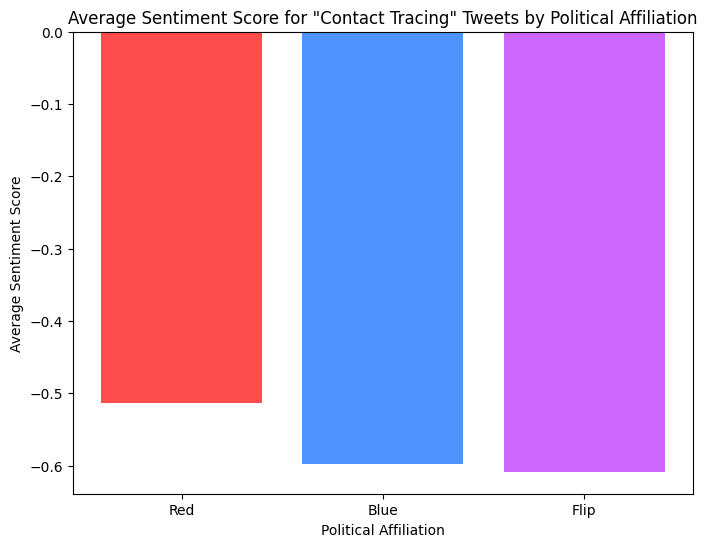

/var/folders/q4/7sz5khj51k3c5cv3fz08lsb40000gn/T/ipykernel_30623/369891719.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_contact, x='political_affil', y='sent_vader', palette=color_palette)


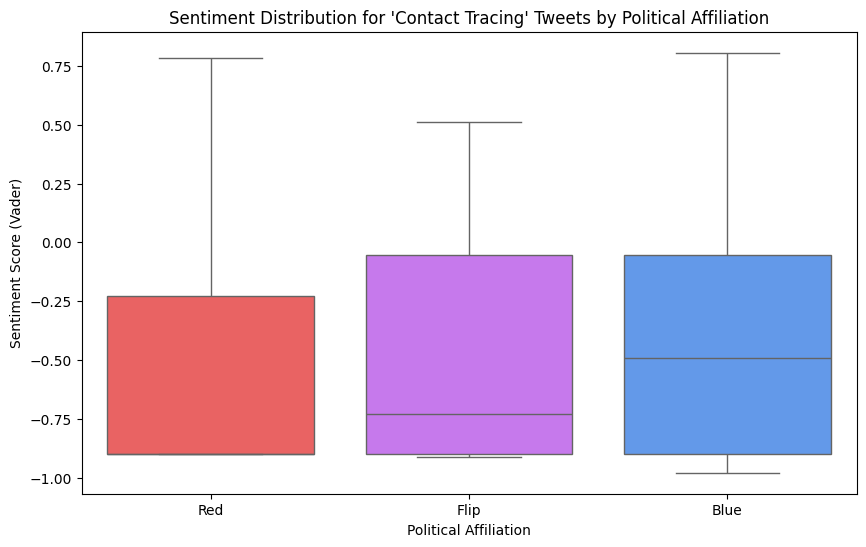

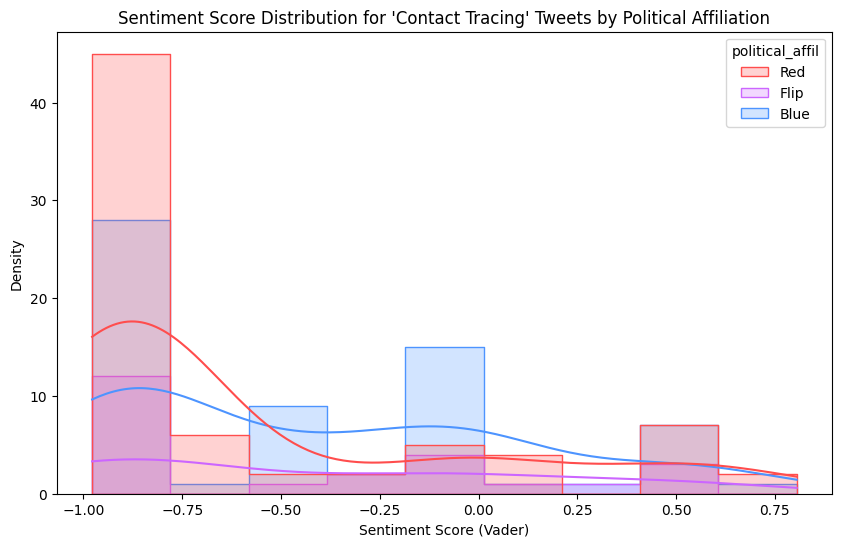

In [96]:
# Calculate the average sentiment score 
red_sentiment_contact = df[df['contact'] & (df['political_affil'] == 'Red')]['sent_vader'].mean()
blue_sentiment_contact = df[df['contact'] & (df['political_affil'] == 'Blue')]['sent_vader'].mean()
flip_sentiment_contact = df[df['contact'] & (df['political_affil'] == 'Flip')]['sent_vader'].mean()

affiliations = ['Red', 'Blue', 'Flip']
sentiment_scores_contact = [red_sentiment_contact, blue_sentiment_contact, flip_sentiment_contact]

# bar plot
plt.figure(figsize=(8, 6))
plt.bar(affiliations, sentiment_scores_contact, color=['#ff4d4d', '#4d94ff', '#cc66ff'])
plt.xlabel('Political Affiliation')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Score for "Contact Tracing" Tweets by Political Affiliation')
plt.savefig('08_tracing_avg.png')
plt.show();



# filtering
df_contact = df[df['contact']]
df_contact = df_cov[df_cov['political_affil'] != 'Unknown']

color_palette = {"Red": "#ff4d4d", "Blue": "#4d94ff", "Flip": "#cc66ff"}

# box plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_contact, x='political_affil', y='sent_vader', palette=color_palette)
plt.title("Sentiment Distribution for 'Contact Tracing' Tweets by Political Affiliation")
plt.xlabel("Political Affiliation")
plt.ylabel("Sentiment Score (Vader)")
plt.savefig('09_tracing_distrib.png')
plt.show();

# KDE plot 
plt.figure(figsize=(10, 6))
sns.histplot(data=df_contact, x='sent_vader', hue='political_affil', kde=True, element="step", palette=color_palette)
plt.title("Sentiment Score Distribution for 'Contact Tracing' Tweets by Political Affiliation")
plt.xlabel("Sentiment Score (Vader)")
plt.ylabel("Density")
plt.savefig('10_tracing_kde.png')
plt.show();


In [97]:
# Extract individual sentiment values 
red_sentiment_contact = df[df['contact'] & (df['political_affil'] == 'Red')]['sent_vader']
blue_sentiment_contact = df[df['contact'] & (df['political_affil'] == 'Blue')]['sent_vader']
flip_sentiment_contact = df[df['contact'] & (df['political_affil'] == 'Flip')]['sent_vader']

# Combine data 
data = pd.concat([
    pd.DataFrame({'sentiment': red_sentiment_contact, 'group': 'Red'}),
    pd.DataFrame({'sentiment': blue_sentiment_contact, 'group': 'Blue'}),
    pd.DataFrame({'sentiment': flip_sentiment_contact, 'group': 'Flip'})
])

# Perform Tukey's HSD test
tukey_result_contact = pairwise_tukeyhsd(endog=data['sentiment'], groups=data['group'], alpha=0.10)
print(tukey_result_contact)

# Converting to image
#result_str_contact = tukey_result_vacc.summary().as_text()
#fig, ax = plt.subplots(figsize=(10, 5))
#ax.axis('off')
#ax.text(0.01, 0.99, result_str_contact, transform=ax.transAxes, fontsize=10,
#        verticalalignment='top', family='monospace')
#plt.savefig('11_lockdown_tukey.png')


Multiple Comparison of Means - Tukey HSD, FWER=0.10
group1 group2 meandiff p-adj   lower  upper  reject
---------------------------------------------------
  Blue   Flip   -0.011 0.9759 -0.1189 0.0969  False
  Blue    Red   0.0841 0.0541  0.0095 0.1586   True
  Flip    Red   0.0951 0.1928 -0.0176 0.2077  False
---------------------------------------------------


### Keyword: "stimulus check"

#### Not statistically significant

In [98]:
# Testing stimulus check
df["stim"] = df.rt_text.str.lower().str.contains("stimulus check")
df[ df.stim & (df.political_affil == "Red") ].sent_vader.mean()
df[ df.stim & (df.political_affil == "Blue") ].sent_vader.mean()
df[ df.stim & (df.political_affil == "Flip") ].sent_vader.mean()

compare_sentiment(df, 'stim')

0.07390979261090509

0.12496635536747895

0.10066750182882225

Red normality p-value: 6.99237992386757e-60
Blue normality p-value: 3.395276580712081e-70
Flip normality p-value: 3.253739192182469e-43
Levene test p-value: 1.3218538603998283e-15
Kruskal-Wallis p-value: 4.432345885072791e-17


/opt/anaconda3/envs/qss20/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 14562.
  res = hypotest_fun_out(*samples, **kwds)
/opt/anaconda3/envs/qss20/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 20559.
  res = hypotest_fun_out(*samples, **kwds)
/opt/anaconda3/envs/qss20/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5468.
  res = hypotest_fun_out(*samples, **kwds)


### Keyword: "small business relief"

#### Not statistically significant

In [99]:
# Testing small business relief
df["relief"] = df.rt_text.str.lower().str.contains("small business relief")
df[ df.relief & (df.political_affil == "Red") ].sent_vader.mean()
df[ df.relief & (df.political_affil == "Blue") ].sent_vader.mean()
df[ df.relief & (df.political_affil == "Flip") ].sent_vader.mean()

compare_sentiment(df, 'relief')

0.17438974358974363

0.05773278688524593

0.002118181818181807

Red normality p-value: 9.625691345164006e-05
Blue normality p-value: 1.0690791515204515e-06
Flip normality p-value: 0.17425975870108557
Levene test p-value: 0.97498320343275
Kruskal-Wallis p-value: 0.4657301079458941


### Keyword: "quarantine"

#### Not statistically significant

In [100]:
# Testing quarantine
df["quarantine"] = df.rt_text.str.lower().str.contains("quarantine")
df[ df.quarantine & (df.political_affil == "Red") ].sent_vader.mean()
df[ df.quarantine & (df.political_affil == "Blue") ].sent_vader.mean()
df[ df.quarantine & (df.political_affil == "Flip") ].sent_vader.mean()

compare_sentiment(df, 'quarantine')

-0.332987323943662

-0.45574568965517237

-0.4137310344827585

Red normality p-value: 9.911173504773666e-08
Blue normality p-value: 8.495545055689925e-10
Flip normality p-value: 1.2211047873559736e-05
Levene test p-value: 0.3102097466230629
Kruskal-Wallis p-value: 0.5072353419530796


### Keyword: "travel restrict"

#### Not statistically significant

In [101]:
# Testing travel restrict
df["travel"] = df.rt_text.str.lower().str.contains("travel restrict")
df[ df.travel & (df.political_affil == "Red") ].sent_vader.mean()
df[ df.travel & (df.political_affil == "Blue") ].sent_vader.mean()
df[ df.travel & (df.political_affil == "Flip") ].sent_vader.mean()


-0.16705714285714285

-0.11014999999999998

nan

### Keyword: "biden"

#### Statistically significant at the 10% level

In [102]:
# Testing biden
df["biden_gen"] = df.rt_text.str.lower().str.contains("biden")
df[ df.biden_gen & (df.political_affil == "Red") ].sent_vader.mean()
df[ df.biden_gen & (df.political_affil == "Blue") ].sent_vader.mean()
df[ df.biden_gen & (df.political_affil == "Flip") ].sent_vader.mean()

compare_sentiment(df, 'biden_gen')


-0.08217118758434547

-0.0556093007739525

-0.07601360116166506

Red normality p-value: 4.898518477981321e-49
Blue normality p-value: 5.1025642405079094e-51
Flip normality p-value: 2.121204821753079e-31
Levene test p-value: 0.08550951546879872
Kruskal-Wallis p-value: 0.03461742514643684


/opt/anaconda3/envs/qss20/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5928.
  res = hypotest_fun_out(*samples, **kwds)
/opt/anaconda3/envs/qss20/lib/python3.9/site-packages/scipy/stats/_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 7494.
  res = hypotest_fun_out(*samples, **kwds)


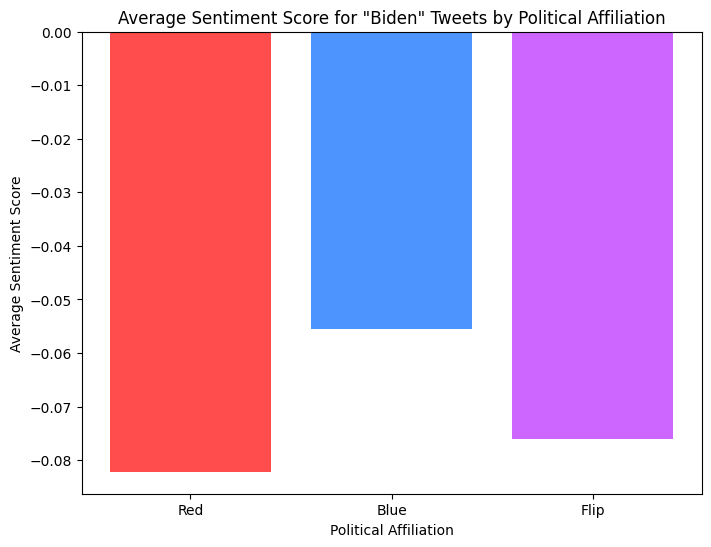

/var/folders/q4/7sz5khj51k3c5cv3fz08lsb40000gn/T/ipykernel_30623/3234839771.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_biden, x='political_affil', y='sent_vader', palette=color_palette)


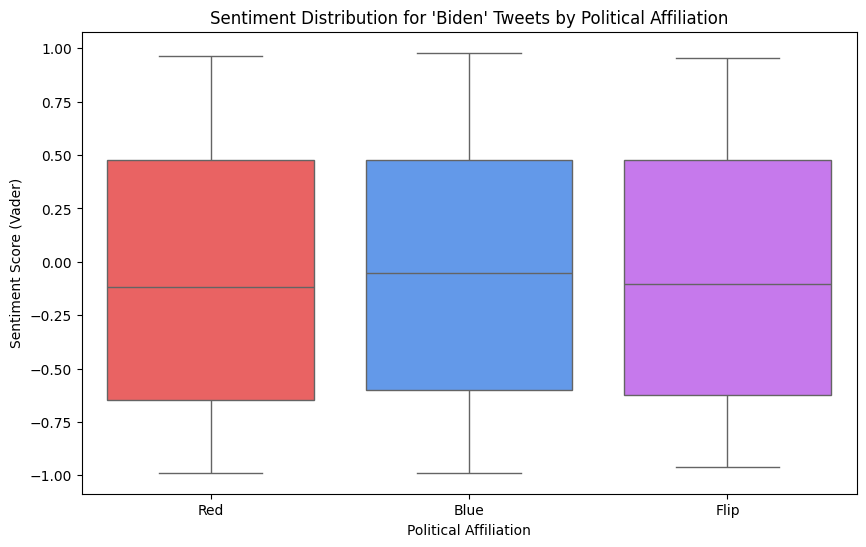

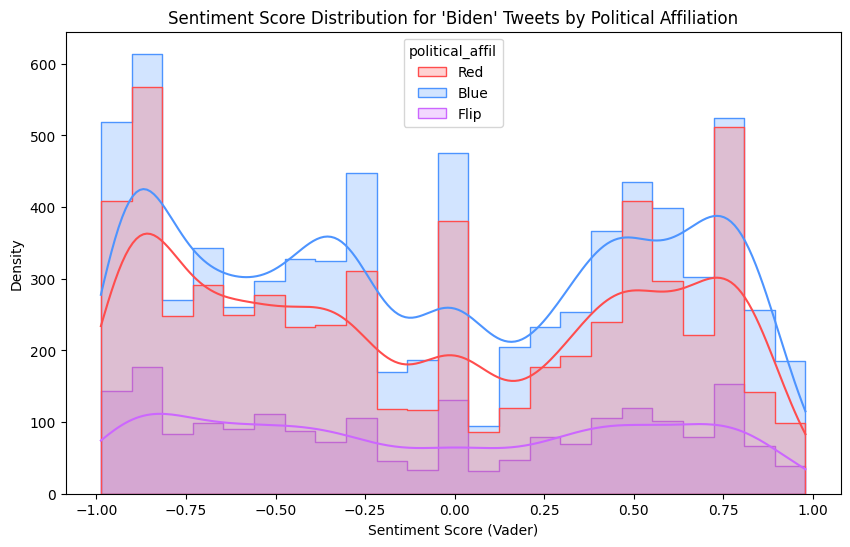

In [103]:
# Calculate the average sentiment score 
red_sentiment_biden = df[df['biden_gen'] & (df['political_affil'] == 'Red')]['sent_vader'].mean()
blue_sentiment_biden = df[df['biden_gen'] & (df['political_affil'] == 'Blue')]['sent_vader'].mean()
flip_sentiment_biden = df[df['biden_gen'] & (df['political_affil'] == 'Flip')]['sent_vader'].mean()

# Prepare data 
affiliations = ['Red', 'Blue', 'Flip']
sentiment_scores_biden = [red_sentiment_biden, blue_sentiment_biden, flip_sentiment_biden]

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.bar(affiliations, sentiment_scores_biden, color=['#ff4d4d', '#4d94ff', '#cc66ff'])
plt.xlabel('Political Affiliation')
plt.ylabel('Average Sentiment Score')
plt.title('Average Sentiment Score for "Biden" Tweets by Political Affiliation')
plt.savefig('12_biden_avg.png')
plt.show();


# Filter the DataFrame 
df_biden = df[df['biden_gen']]
df_biden = df_biden[df_biden['political_affil'] != 'Unknown']

color_palette = {"Red": "#ff4d4d", "Blue": "#4d94ff", "Flip": "#cc66ff"}

# Box plot 
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_biden, x='political_affil', y='sent_vader', palette=color_palette)
plt.title("Sentiment Distribution for 'Biden' Tweets by Political Affiliation")
plt.xlabel("Political Affiliation")
plt.ylabel("Sentiment Score (Vader)")
plt.savefig('13_biden_distrib.png')
plt.show();

# KDE plot 
plt.figure(figsize=(10, 6))
sns.histplot(data=df_biden, x='sent_vader', hue='political_affil', kde=True, element="step", palette=color_palette)
plt.title("Sentiment Score Distribution for 'Biden' Tweets by Political Affiliation")
plt.xlabel("Sentiment Score (Vader)")
plt.ylabel("Density")
plt.savefig('14_biden_kde.png')
plt.show();


In [104]:
# Extract individual sentiment values
red_sentiment_biden = df[df['biden_gen'] & (df['political_affil'] == 'Red')]['sent_vader']
blue_sentiment_biden = df[df['biden_gen'] & (df['political_affil'] == 'Blue')]['sent_vader']
flip_sentiment_biden = df[df['biden_gen'] & (df['political_affil'] == 'Flip')]['sent_vader']

# Combine data
data = pd.concat([
    pd.DataFrame({'sentiment': red_sentiment_biden, 'group': 'Red'}),
    pd.DataFrame({'sentiment': blue_sentiment_biden, 'group': 'Blue'}),
    pd.DataFrame({'sentiment': flip_sentiment_biden, 'group': 'Flip'})
])

# Perform Tukey's HSD test
tukey_result_biden = pairwise_tukeyhsd(endog=data['sentiment'], groups=data['group'], alpha=0.05)
print(tukey_result_biden)

# Converting to image
#result_str_biden = tukey_result_vacc.summary().as_text()
#fig, ax = plt.subplots(figsize=(10, 5))
#ax.axis('off')
#ax.text(0.01, 0.99, result_str_biden, transform=ax.transAxes, fontsize=10,
#        verticalalignment='top', family='monospace')
#plt.savefig('15_biden_tukey.png')


Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
  Blue   Flip  -0.0204 0.3646 -0.0557  0.0149  False
  Blue    Red  -0.0266 0.0313 -0.0512 -0.0019   True
  Flip    Red  -0.0062 0.9165 -0.0424  0.0301  False
----------------------------------------------------
